# soilgrids

This package provides a minimal wrapper for the ISRIC Soilgrids API, allowing 
users to query soil properties by latitude/longitude and perform basic 
analyses on the returned data.

Functions:

*   `get_soilgrids()`: Provides a simple wrapper for the /properties/query
    API endpoint, parsing the geojson response into a pandas DataFrame.
        
Classes:

*   `SoilGrids()`: Provides methods for reading data from Soilgrids and basic 
    including utilities for aggregating and analysing the returned data.

Useful links:

*   Documentation for the API: <https://rest.isric.org/soilgrids/v2.0/docs>
*   ISRIC REST entry page, including fair use policy: <https://rest.isric.org>
*   ISRIC data and software policy: <https://www.isric.org/about/data-policy>
*   Soilgrids FAQ: <https://www.isric.org/explore/soilgrids/faq-soilgrids>

## Querying data using `SoilGrids`

The following code reads in the mean values for clay, sand, silt, and organic 
carbon stock (OCS) in the top 30cm of soil for a random set of 50 points 
within roughly 25km of 
[Herning, Denmark](https://en.wikipedia.org/wiki/Herning). Points can be queried 
at a maximum rate of 5/minute, so the following code takes about 10 minutes to 
run:

In [1]:
from IPython.display import Markdown, Image
from soilgrids import SoilGrids
import logging
import plotly.io as pio
import plotly.offline as po

# Turn off console logs for cleaner notebook output
logging.getLogger('soilgrids').setLevel(logging.ERROR)

# Helper for displaying tables as markdown
show = lambda df: display(Markdown(df.to_markdown(index=False)))

sg = SoilGrids()

# get_points_sample() reads in a uniformly distributed random sample of
# points within specified bounds. If you want to query an exact set of
# points, you can use `SoilGrids.get_points()`.
sg.get_points_sample(
    50,
    lat_a=56.225297, lon_a=8.662215,
    lat_b=55.958103, lon_b=9.354390,
    soil_property=['clay', 'sand', 'silt', 'ocs'],
    depth=['0-5cm', '5-15cm', '15-30cm', '0-30cm'],
    value='mean'
)

# Once Soilgrids has been queried, the results are accessible using the 
# `data` property. For brevity, only a subset of the data is shown here.
show(sg.data[0:15].filter([
    'lat', 'lon', 'soil_property', 'mapped_units', 
    'target_units', 'depth', 'mean'
]))

|     lat |     lon | soil_property   | mapped_units   | target_units   | depth   |   mean |
|--------:|--------:|:----------------|:---------------|:---------------|:--------|-------:|
| 56.0024 | 9.17168 | clay            | g/kg           | %              | 0-5cm   |     93 |
| 56.0024 | 9.17168 | clay            | g/kg           | %              | 5-15cm  |     90 |
| 56.0024 | 9.17168 | clay            | g/kg           | %              | 15-30cm |     85 |
| 56.0024 | 9.17168 | ocs             | t/ha           | kg/m²          | 0-30cm  |     69 |
| 56.0024 | 9.17168 | sand            | g/kg           | %              | 0-5cm   |    802 |
| 56.0024 | 9.17168 | sand            | g/kg           | %              | 5-15cm  |    804 |
| 56.0024 | 9.17168 | sand            | g/kg           | %              | 15-30cm |    820 |
| 56.0024 | 9.17168 | silt            | g/kg           | %              | 0-5cm   |    105 |
| 56.0024 | 9.17168 | silt            | g/kg           | %              | 5-15cm  |    106 |
| 56.0024 | 9.17168 | silt            | g/kg           | %              | 15-30cm |     95 |
| 56.1016 | 8.93631 | clay            | g/kg           | %              | 0-5cm   |     63 |
| 56.1016 | 8.93631 | clay            | g/kg           | %              | 5-15cm  |     58 |
| 56.1016 | 8.93631 | clay            | g/kg           | %              | 15-30cm |     83 |
| 56.1016 | 8.93631 | ocs             | t/ha           | kg/m²          | 0-30cm  |     59 |
| 56.1016 | 8.93631 | sand            | g/kg           | %              | 0-5cm   |    805 |

## Get the property (clay, sand, silt) with the highest value for each point

The `SoilGrids` class provides a handy utility `main_properties()` for finding
the most abundant soil type (i.e. property) for each point. In this case, we
see that the Herning region is quite sandy:

In [2]:
show(sg.main_properties())

|     lat |     lon | soil_property   |
|--------:|--------:|:----------------|
| 55.9681 | 9.19413 | sand            |
| 55.969  | 8.84612 | sand            |
| 55.9736 | 9.26458 | sand            |
| 55.988  | 9.06893 | sand            |
| 56.0024 | 9.17168 | sand            |
| 56.0071 | 8.73347 | sand            |
| 56.0079 | 9.1555  | sand            |
| 56.0115 | 9.19478 | sand            |
| 56.0116 | 9.11962 | sand            |
| 56.0129 | 9.06321 | sand            |
| 56.0152 | 9.09177 | sand            |
| 56.0209 | 9.04625 | sand            |
| 56.0215 | 9.01066 | sand            |
| 56.0218 | 9.32185 | sand            |
| 56.0227 | 8.77494 | sand            |
| 56.0245 | 8.98394 | sand            |
| 56.0293 | 8.80021 | sand            |
| 56.0312 | 9.20504 | sand            |
| 56.0312 | 9.33958 | sand            |
| 56.0322 | 9.13423 | sand            |
| 56.0327 | 8.69833 | sand            |
| 56.0335 | 8.82781 | sand            |
| 56.0421 | 8.89465 | sand            |
| 56.0457 | 9.2178  | sand            |
| 56.0524 | 9.05007 | sand            |
| 56.0591 | 9.0177  | sand            |
| 56.0706 | 9.04175 | sand            |
| 56.0731 | 9.1996  | sand            |
| 56.0768 | 9.11822 | sand            |
| 56.0801 | 8.89161 | sand            |
| 56.0936 | 8.88005 | sand            |
| 56.1016 | 8.93631 | sand            |
| 56.1029 | 9.29378 | sand            |
| 56.1034 | 9.1627  | sand            |
| 56.1084 | 9.21805 | sand            |
| 56.1126 | 8.80794 | sand            |
| 56.1153 | 8.81545 | sand            |
| 56.1223 | 9.24917 | sand            |
| 56.1239 | 8.72794 | sand            |
| 56.124  | 8.96254 | sand            |
| 56.127  | 8.91474 | sand            |
| 56.1365 | 9.0808  | sand            |
| 56.1462 | 8.93131 | clay            |
| 56.1644 | 9.26652 | sand            |
| 56.1707 | 8.92046 | sand            |
| 56.177  | 8.82983 | sand            |
| 56.1878 | 9.00154 | sand            |
| 56.2074 | 9.23711 | sand            |
| 56.2128 | 9.33269 | sand            |
| 56.2192 | 8.77554 | sand            |

## Relationship between clay, sand, silt and organic carbon stock

The `ocs_correlation()` method fits and displays summary statistics for a linear 
model with sand, clay and silt as predictors and OCS as the response variable. 
Based on the R-squared values returned in the summary, it doesn't look like 
these soil properties are particularly good predictors for OCS in this case:

In [3]:
print(sg.ocs_correlation(capture_output=True))


Call:
lm(formula = clay + sand + silt ~ ocs, data = soilgrids_summary, 
    na.action = na.omit)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.90210 -0.83803  0.07654  0.14061  2.11926 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1000.55348    1.25964 794.314   <2e-16 ***
ocs           -0.01068    0.02040  -0.523    0.603    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.948 on 47 degrees of freedom
Multiple R-squared:  0.005796,	Adjusted R-squared:  -0.01536 
F-statistic: 0.274 on 1 and 47 DF,  p-value: 0.6031




## Additional features

### Method `SoilGrids.plot_ocs_property_relationships()`

The `plot_ocs_property_relationships()` method can be used to obtain a graphical
representation of the relationships between OCS and the other soil properties 
present in the data. These are displayed as scatterplots with overlayed lines
of best fit, i.e. the values predicted by a fitted linear regression.

In this case we can see that there is no panel where the plotted points show
strong agreement with the fitted line. This agrees with the low value for 
R-squared obtained earlier:

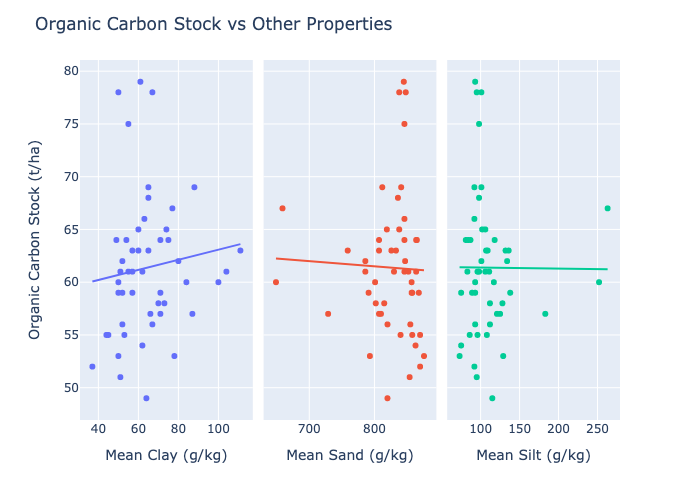

In [4]:
fig = sg.plot_ocs_property_relationships()

fig.write_image("README_files/ocs_property_relationships.png")
Image("README_files/ocs_property_relationships.png")

### Method `SoilGrids.plot_property_map()`

The `plot_property_map()` method can display the points as they appear 
geographically. The points are sized according to the value of the property
you choose to plot, and the tooltip displays the values for other properties
present in the data:

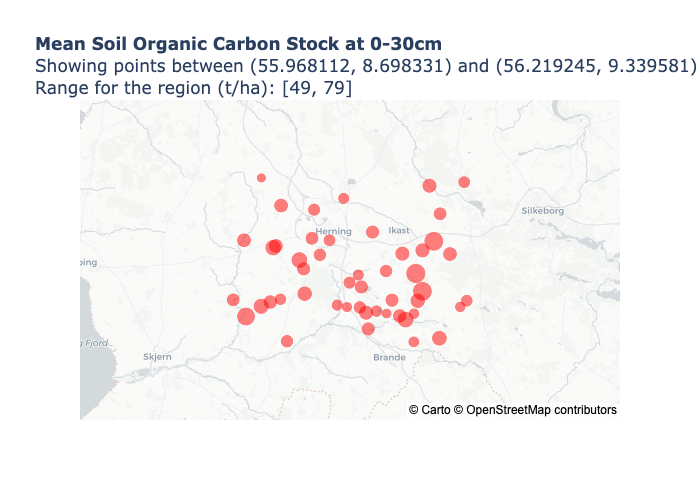

In [5]:
fig = sg.plot_property_map('ocs', zoom=8)

fig.write_image("README_files/property_map.png")
Image("README_files/property_map.png")

## Method `SoilGrids.aggregate_means()`

Working with data from SoilGrids poses a challenge since different soil 
properties are measured at different levels of granularity. For example, values
for clay will be provided at 0-5cm, 5-15cm, and 15-30cm, whereas OCS will be 
provided as a single value for 0-30cm as a whole.

In order to easily compare, say, `ocs` with `clay`, we need to
aggregate the values for `clay` to get a representative measurement for the 
whole 0-30cm. However, the 3 values for clay cover 5, 10 and 15 cm of depth
respectively, so we can't simply take the mean across each value.

`SoilGrids.aggregate_means()` is a utility for aggregating Soilgrids data whilst
weighting individual values according to the total depth they represent, and 
it is used to power other methods such as `plot_ocs_property_relationships()`, 
`plot_property_map()` and `ocs_correlation()`. The following shows how values
are aggregated for a single point:

In [9]:
small_datasets = [
    dataset \
        .filter(['lat', 'lon', 'soil_property', 'depth', 'mean']) \
        .query(
            "lat == 55.968112 & lon == 9.194132 &"
            "soil_property in ['clay', 'ocs']"
        )
    for dataset in [sg.data, sg.aggregate_means(top_depth=0, bottom_depth=30)]
]

for dataset in small_datasets:
    show(dataset)

|     lat |     lon | soil_property   | depth   |   mean |
|--------:|--------:|:----------------|:--------|-------:|
| 55.9681 | 9.19413 | clay            | 0-5cm   |     58 |
| 55.9681 | 9.19413 | clay            | 5-15cm  |     49 |
| 55.9681 | 9.19413 | clay            | 15-30cm |     72 |
| 55.9681 | 9.19413 | ocs             | 0-30cm  |     54 |

|     lat |     lon | soil_property   | depth   |   mean |
|--------:|--------:|:----------------|:--------|-------:|
| 55.9681 | 9.19413 | clay            | 0-30cm  |     62 |
| 55.9681 | 9.19413 | ocs             | 0-30cm  |     54 |

## Testing

This package is thoroughly tested using 
[pytest](https://docs.pytest.org/en/7.4.x/). To run the test suite, use:

```bash
python -m pytest tests
```

## Disclaimers

*   Use of Soilgrids data is subject to [ISRIC data and software policy](https://www.isric.org/about/data-policy).
*   This package is licensed as [GPL-2](LICENSE).